In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from lib.LinOSS import LinOSS
from lib.dataset import PDEDataset

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import optax

In [2]:
sns.set_context("paper")
sns.set_style("whitegrid")

In [3]:
torch.manual_seed(0)
np.random.seed(0)
key = jr.PRNGKey(0)

In [4]:
BATCH_SIZE = 32

In [ ]:
@eqx.filter_jit
@eqx.filter_value_and_grad(has_aux=True)
def rel_l2_loss(model: LinOSS, X, y, state, key):
    pred_y, state = jax.vmap(
        model, axis_name="batch", in_axes=(0, None, None), out_axes=(0, None)
    )(X, state, key)

    loss = jnp.mean(jnp.square(pred_y - y) / jnp.square(y))

    return loss, state

In [6]:
@eqx.filter_jit
def make_step(model, X, y, loss_fn, state, opt, opt_state, key):

    (value, state), grads = loss_fn(model, X, y, state, key)
    updates, opt_state = opt.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    return model, state, opt_state, value

In [7]:
training_data = PDEDataset("data/train_sol.npy", device="cpu")
# choose N_TRAIN samples randomly
val_data, train_data = torch.utils.data.random_split(training_data, [0.2, 0.8])

In [8]:
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

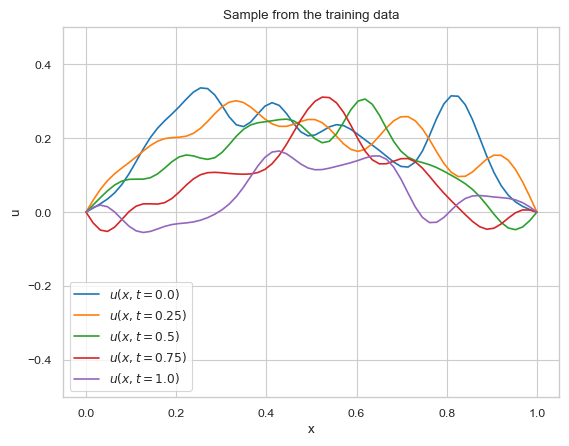

In [9]:
# plot a random sample from the training data
sample = training_data.data[np.random.randint(0, len(train_data))]
for t in range(len(sample)):
    plt.plot(
        sample[t, :, 1].cpu().numpy(),
        sample[t, :, 0].cpu().numpy(), label=f'$u(x, t={t / 4})$')

plt.ylim(-0.5, 0.5)
plt.xlabel("x")
plt.ylabel("u")
plt.title("Sample from the training data")
plt.legend()

In [10]:
learning_rate = 0.001
epochs = 100
step_size = 100
gamma = 0.75

In [11]:
model = LinOSS(
    num_blocks=6,
    N=64,
    ssm_size=256,
    H=128,
    output_dim=64,
    classification=False,
    output_step=1,
    discretization="IM",
    key=key,
)

In [12]:
lr_scheduler = optax.cosine_decay_schedule(learning_rate, step_size, gamma)
opt = optax.adam(learning_rate=lr_scheduler)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))
state = eqx.nn.State(model=model)

In [13]:
metrics = {
    "training_loss": [],
    "validation_loss": [],
    "lr": [],
}

running_loss = 0

progress_bar = tqdm.tqdm(range(epochs))
for epoch in progress_bar:
    for input, target in train_data_loader:
        epoch_key, key = jr.split(key, 2)
        model, state, opt_state, value = make_step(
            model,
            input[..., 0].numpy(),
            target[:, 1:].numpy(),
            rel_l2_loss,
            state=state,
            opt=opt,
            opt_state=opt_state,
            key=epoch_key,
        )
        # save metrics
        running_loss += value
    metrics["training_loss"].append(running_loss / len(train_data_loader))
    running_loss = 0

print("Training done")

  0%|          | 0/100 [00:00<?, ?it/s]/Users/ben/Desktop/temp/LinOSSM_Torch/.venv/lib/python3.12/site-packages/jax/_src/lax/lax.py:4791: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


y: [[[ 0.00000000e+00  3.03883851e-02  5.30931987e-02 ... -3.95819247e-02
   -2.01051738e-02 -4.29901415e-17]
  [ 0.00000000e+00 -1.35779502e-02 -2.04347912e-02 ... -1.45639488e-02
   -5.21159824e-03 -5.53278877e-17]
  [ 0.00000000e+00 -1.10070743e-02 -1.98117066e-02 ... -6.58207312e-02
   -3.29249837e-02 -3.01324195e-17]
  [ 0.00000000e+00 -6.41855896e-02 -1.27144307e-01 ...  1.28616975e-03
    2.08156370e-03 -2.10535019e-17]]

 [[ 0.00000000e+00  5.72710149e-02  1.07504964e-01 ...  1.08167745e-01
    5.57457134e-02  1.36210482e-16]
  [ 0.00000000e+00  1.57735161e-02  3.27553377e-02 ...  8.44677985e-02
    4.22532670e-02  7.43519036e-17]
  [ 0.00000000e+00  3.95045616e-02  7.91246071e-02 ...  1.03350803e-02
    4.33789659e-03  6.98699611e-17]
  [ 0.00000000e+00 -2.81132106e-03 -2.52813497e-03 ... -2.73033191e-04
    1.57146819e-03 -4.69636789e-17]]

 [[ 0.00000000e+00  4.16642837e-02  8.51277187e-02 ...  1.34217262e-01
    6.74170926e-02  1.32444189e-16]
  [ 0.00000000e+00  1.23056127

  2%|▏         | 2/100 [00:06<04:44,  2.90s/it]

y: [[[ 0.00000000e+00  1.81915071e-02  3.74200828e-02 ... -9.38740894e-02
   -5.15939258e-02 -1.92281416e-16]
  [ 0.00000000e+00  5.69065958e-02  1.10733561e-01 ... -4.26613819e-03
   -1.21793372e-03  5.05954981e-17]
  [ 0.00000000e+00 -1.90328956e-02 -3.41058597e-02 ... -1.63389072e-02
   -7.94635527e-03 -9.18886818e-17]
  [ 0.00000000e+00 -4.45159115e-02 -8.75728726e-02 ...  5.24680652e-02
    2.85483375e-02  1.39316895e-16]]

 [[ 0.00000000e+00  7.82180578e-03  6.21211249e-03 ...  3.02452240e-02
    1.76153872e-02  6.74494189e-17]
  [ 0.00000000e+00 -4.07388397e-02 -7.79306144e-02 ... -9.69170220e-03
   -2.76316027e-03 -4.07256452e-17]
  [ 0.00000000e+00 -2.87969485e-02 -5.30065484e-02 ... -5.24381101e-02
   -2.47475840e-02  2.43358455e-17]
  [ 0.00000000e+00 -1.16411950e-02 -2.42125317e-02 ... -1.35597810e-01
   -7.08117187e-02 -2.63092007e-16]]

 [[ 0.00000000e+00  2.32640654e-02  4.56587672e-02 ... -4.79946844e-02
   -2.53380183e-02 -6.19387019e-17]
  [ 0.00000000e+00 -1.89305060

  4%|▍         | 4/100 [00:07<01:38,  1.02s/it]

y: [[[ 0.00000000e+00  5.36916889e-02  1.02093011e-01 ...  4.01321128e-02
    2.27805302e-02  6.57827161e-17]
  [ 0.00000000e+00  1.86921586e-03  6.26842305e-03 ... -1.99912954e-02
   -1.06573580e-02 -6.07614386e-17]
  [ 0.00000000e+00  1.53173907e-02  3.17707025e-02 ... -1.39614223e-02
   -8.22391920e-03  3.17292255e-17]
  [ 0.00000000e+00  5.19822445e-03  7.65772024e-03 ...  1.10408291e-01
    5.67453578e-02  9.93647137e-17]]

 [[ 0.00000000e+00  3.95214856e-02  7.53341094e-02 ...  1.18043117e-01
    5.94559610e-02  1.73175608e-16]
  [ 0.00000000e+00 -1.35851512e-02 -1.24503458e-02 ...  5.00050234e-03
    3.01979738e-03 -4.33794325e-17]
  [ 0.00000000e+00  2.55825557e-02  4.82416414e-02 ... -5.59580885e-03
   -2.98101967e-03 -9.17875176e-18]
  [ 0.00000000e+00  9.94249992e-03  1.90109611e-02 ...  7.22382069e-02
    3.97000164e-02  1.45706515e-16]]

 [[ 0.00000000e+00  3.20685804e-02  6.55411631e-02 ...  9.02620181e-02
    4.66151386e-02  3.60249598e-17]
  [ 0.00000000e+00  3.59004438

  6%|▌         | 6/100 [00:07<00:50,  1.87it/s]

pred: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
y: [[[ 0.00000000e+00  4.74479124e-02  8.92366171e-02 ... -6.31600793e-04
    5.06686920e-04 -2.94090336e-17]
  [ 0.00000000e+00 -5.43820895e-02 -1.04941614e-01 ... -2.79184077e-02
   -1.66327357e-02 -8.67829062e-1

  8%|▊         | 8/100 [00:07<00:30,  3.06it/s]

pred: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
y: [[[ 0.00000000e+00  2.16622166e-02  4.34695631e-02 ...  7.18552396e-02
    3.66225354e-02  4.41850899e-17]
  [ 0.00000000e+00  4.12262008e-02  7.91947693e-02 ...  3.39054540e-02
    1.79138202e-02  4.28995784e-1

 10%|█         | 10/100 [00:07<00:21,  4.26it/s]

y: [[[ 0.00000000e+00  3.47215049e-02  6.80076033e-02 ... -3.84563692e-02
   -1.59070436e-02  2.54285639e-18]
  [ 0.00000000e+00 -1.69304032e-02 -3.08886878e-02 ... -1.02163367e-01
   -5.49594127e-02 -2.01838885e-16]
  [ 0.00000000e+00 -4.43224125e-02 -9.38822702e-02 ... -3.27428803e-02
   -1.85607933e-02 -2.09495782e-17]
  [ 0.00000000e+00 -4.78581265e-02 -9.63458866e-02 ...  2.68958192e-02
    1.54834921e-02  5.39689392e-17]]

 [[ 0.00000000e+00  1.89515445e-02  4.08995710e-02 ...  7.84441605e-02
    4.34253737e-02  1.30594296e-16]
  [ 0.00000000e+00  2.22931076e-02  4.61271629e-02 ... -4.64690290e-02
   -2.64900345e-02 -1.18336736e-16]
  [ 0.00000000e+00  3.01025659e-02  5.55183701e-02 ...  3.48678492e-02
    1.51040452e-02  7.14917777e-17]
  [ 0.00000000e+00  2.34657098e-02  4.34310734e-02 ...  9.22490582e-02
    4.79958877e-02  1.13033728e-16]]

 [[ 0.00000000e+00  7.55180642e-02  1.40528068e-01 ...  9.26834121e-02
    4.74719442e-02  1.11378215e-16]
  [ 0.00000000e+00  5.05780848

 12%|█▏        | 12/100 [00:08<00:15,  5.65it/s]

y: [[[ 0.0000000e+00 -4.3692764e-02 -9.1300122e-02 ... -4.3485757e-02
   -2.3268675e-02 -7.6429153e-17]
  [ 0.0000000e+00 -3.5211250e-02 -6.4132236e-02 ... -4.6086106e-02
   -2.2409065e-02 -1.0225005e-16]
  [ 0.0000000e+00  3.5747911e-03  1.3231974e-02 ... -8.8171951e-02
   -4.4433922e-02 -7.7980924e-17]
  [ 0.0000000e+00  5.4155789e-02  9.6668035e-02 ...  1.3431611e-02
    8.4000835e-03  3.2617836e-17]]

 [[ 0.0000000e+00 -3.1566657e-02 -6.3679382e-02 ... -5.5706885e-02
   -2.5339203e-02 -4.3185601e-17]
  [ 0.0000000e+00 -2.0923374e-02 -5.0090324e-02 ... -6.7220509e-02
   -3.3817820e-02 -9.6872108e-17]
  [ 0.0000000e+00 -2.7300758e-02 -5.4957774e-02 ... -1.0528672e-02
   -8.0079082e-03  5.8832771e-17]
  [ 0.0000000e+00  8.5276878e-03  1.9882444e-02 ...  4.5560021e-03
    2.5581259e-03 -9.6880942e-17]]

 [[ 0.0000000e+00  4.4873033e-02  9.2654690e-02 ...  3.8406592e-02
    1.8714616e-02  8.8492735e-17]
  [ 0.0000000e+00  4.2291347e-02  8.8816687e-02 ...  3.6151465e-02
    1.7243674e-02

 14%|█▍        | 14/100 [00:08<00:12,  6.97it/s]

pred: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
y: [[[ 0.00000000e+00  4.76586819e-02  8.92610103e-02 ...  3.61744389e-02
    2.10279580e-02  9.48813617e-17]
  [ 0.00000000e+00 -1.87681941e-03  3.05341277e-03 ...  4.78448207e-03
    1.67268096e-03 -8.11285907e-1

 16%|█▌        | 16/100 [00:08<00:10,  7.90it/s]

pred: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
y: [[[ 0.00000000e+00 -5.32915033e-02 -1.02433085e-01 ... -1.03103273e-01
   -5.10100573e-02 -1.18269027e-16]
  [ 0.00000000e+00  3.34908022e-04 -1.18013602e-02 ... -1.56907160e-02
   -7.32972519e-03  1.25401408e-1

 18%|█▊        | 18/100 [00:08<00:10,  8.16it/s]

pred: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
y: [[[ 0.00000000e+00  3.11623234e-02  5.88134043e-02 ... -5.74733689e-02
   -2.87174415e-02 -4.07912175e-17]
  [ 0.00000000e+00  4.95714843e-02  9.96642709e-02 ...  8.96254480e-02
    5.11591546e-02  1.14025828e-1

 20%|██        | 20/100 [00:08<00:09,  8.61it/s]

y: [[[ 0.00000000e+00  2.55973153e-02  5.27535528e-02 ...  9.95606557e-02
    4.91374657e-02  1.69324454e-16]
  [ 0.00000000e+00  7.54412636e-02  1.39991418e-01 ... -1.57903880e-02
   -1.26428008e-02 -3.91303844e-17]
  [ 0.00000000e+00  2.46963440e-03  6.76842220e-03 ...  1.89305078e-02
    1.11627234e-02  8.61771403e-18]
  [ 0.00000000e+00  2.88394019e-02  5.71255833e-02 ... -9.73309577e-03
   -6.70000818e-03 -2.36549026e-18]]

 [[ 0.00000000e+00  1.00068673e-02  1.78297162e-02 ... -8.81000087e-02
   -4.15890403e-02 -1.46958946e-16]
  [ 0.00000000e+00 -3.33469063e-02 -7.12509379e-02 ... -1.16851434e-01
   -6.18732646e-02 -1.68314645e-16]
  [ 0.00000000e+00 -6.53199106e-02 -1.28696650e-01 ... -5.50884753e-02
   -2.96031311e-02 -3.09515203e-17]
  [ 0.00000000e+00 -3.51198502e-02 -7.33888149e-02 ... -3.64530087e-02
   -1.69524811e-02 -7.20166669e-17]]

 [[ 0.00000000e+00  7.82180578e-03  6.21211249e-03 ...  3.02452240e-02
    1.76153872e-02  6.74494189e-17]
  [ 0.00000000e+00 -4.07388397

 22%|██▏       | 22/100 [00:09<00:08,  9.10it/s]

y: [[[ 0.00000000e+00 -8.07034373e-02 -1.57869667e-01 ... -8.83737132e-02
   -4.57049496e-02 -1.75202611e-16]
  [ 0.00000000e+00 -1.70394201e-02 -4.17090915e-02 ...  1.90648958e-02
    1.10736247e-02  5.03504574e-17]
  [ 0.00000000e+00 -4.17666622e-02 -7.92950988e-02 ...  6.90407632e-03
    1.86661643e-03  2.79123958e-17]
  [ 0.00000000e+00  3.11171412e-02  5.57691976e-02 ... -1.38959035e-01
   -7.17617422e-02 -2.14237899e-16]]

 [[ 0.00000000e+00  2.48315334e-02  5.00910841e-02 ...  7.03781769e-02
    3.21434028e-02  1.18631689e-16]
  [ 0.00000000e+00  2.51623634e-02  5.59427701e-02 ...  9.77857262e-02
    4.92595397e-02  9.44687905e-17]
  [ 0.00000000e+00  3.05144638e-02  5.68194613e-02 ...  1.11538153e-02
    4.51799948e-03 -3.44043243e-17]
  [ 0.00000000e+00  2.78605223e-02  5.46138100e-02 ...  5.22294194e-02
    2.79918201e-02  1.44739759e-16]]

 [[ 0.00000000e+00 -1.04472907e-02 -2.64172889e-02 ... -2.01879099e-01
   -1.05422825e-01 -2.63866698e-16]
  [ 0.00000000e+00 -7.93123022

 24%|██▍       | 24/100 [00:09<00:08,  8.70it/s]

y: [[[ 0.00000000e+00  1.00068673e-02  1.78297162e-02 ... -8.81000087e-02
   -4.15890403e-02 -1.46958946e-16]
  [ 0.00000000e+00 -3.33469063e-02 -7.12509379e-02 ... -1.16851434e-01
   -6.18732646e-02 -1.68314645e-16]
  [ 0.00000000e+00 -6.53199106e-02 -1.28696650e-01 ... -5.50884753e-02
   -2.96031311e-02 -3.09515203e-17]
  [ 0.00000000e+00 -3.51198502e-02 -7.33888149e-02 ... -3.64530087e-02
   -1.69524811e-02 -7.20166669e-17]]

 [[ 0.00000000e+00  3.76624130e-02  6.89273998e-02 ... -2.88110450e-02
   -1.54403597e-02  2.64066541e-17]
  [ 0.00000000e+00 -3.63167450e-02 -5.90427704e-02 ... -4.18719165e-02
   -1.82227548e-02 -5.28246241e-17]
  [ 0.00000000e+00  5.01549849e-03  5.30131767e-03 ... -6.90292101e-03
   -1.67487958e-03 -3.21871130e-17]
  [ 0.00000000e+00 -2.01575961e-02 -3.72377336e-02 ...  6.73658997e-02
    3.28521915e-02  1.10195009e-16]]

 [[ 0.00000000e+00  8.83741397e-03  1.56031745e-02 ... -1.47784147e-02
   -6.62808213e-03 -2.50724532e-17]
  [ 0.00000000e+00  3.27939540

 26%|██▌       | 26/100 [00:09<00:08,  8.97it/s]

y: [[[ 0.00000000e+00  4.48730327e-02  9.26546901e-02 ...  3.84065919e-02
    1.87146161e-02  8.84927348e-17]
  [ 0.00000000e+00  4.22913469e-02  8.88166875e-02 ...  3.61514650e-02
    1.72436740e-02  6.55287766e-18]
  [ 0.00000000e+00  6.06355304e-03  8.85935407e-03 ... -6.81705475e-02
   -3.48610878e-02 -1.29967650e-16]
  [ 0.00000000e+00 -5.21815382e-02 -1.03358522e-01 ...  4.32312228e-02
    2.35853158e-02  1.40956672e-16]]

 [[ 0.00000000e+00  1.28514168e-03 -5.82549768e-03 ... -7.17098191e-02
   -3.59981842e-02 -9.49168246e-17]
  [ 0.00000000e+00 -3.88528630e-02 -6.96382523e-02 ... -6.06142282e-02
   -3.01501136e-02 -1.24196431e-16]
  [ 0.00000000e+00 -1.25625227e-02 -2.73729879e-02 ... -2.68002842e-02
   -1.44078285e-02  1.15400290e-17]
  [ 0.00000000e+00 -3.06145474e-02 -6.37654066e-02 ... -4.63650860e-02
   -2.24197730e-02 -6.78382467e-17]]

 [[ 0.00000000e+00 -1.73150040e-02 -3.62563431e-02 ...  4.84166145e-02
    2.34937835e-02  6.75396477e-17]
  [ 0.00000000e+00 -3.23268445

 28%|██▊       | 28/100 [00:09<00:07,  9.13it/s]

y: [[[ 0.00000000e+00  5.72710149e-02  1.07504964e-01 ...  1.08167745e-01
    5.57457134e-02  1.36210482e-16]
  [ 0.00000000e+00  1.57735161e-02  3.27553377e-02 ...  8.44677985e-02
    4.22532670e-02  7.43519036e-17]
  [ 0.00000000e+00  3.95045616e-02  7.91246071e-02 ...  1.03350803e-02
    4.33789659e-03  6.98699611e-17]
  [ 0.00000000e+00 -2.81132106e-03 -2.52813497e-03 ... -2.73033191e-04
    1.57146819e-03 -4.69636789e-17]]

 [[ 0.00000000e+00 -8.07034373e-02 -1.57869667e-01 ... -8.83737132e-02
   -4.57049496e-02 -1.75202611e-16]
  [ 0.00000000e+00 -1.70394201e-02 -4.17090915e-02 ...  1.90648958e-02
    1.10736247e-02  5.03504574e-17]
  [ 0.00000000e+00 -4.17666622e-02 -7.92950988e-02 ...  6.90407632e-03
    1.86661643e-03  2.79123958e-17]
  [ 0.00000000e+00  3.11171412e-02  5.57691976e-02 ... -1.38959035e-01
   -7.17617422e-02 -2.14237899e-16]]

 [[ 0.00000000e+00  1.00068673e-02  1.78297162e-02 ... -8.81000087e-02
   -4.15890403e-02 -1.46958946e-16]
  [ 0.00000000e+00 -3.33469063

 29%|██▉       | 29/100 [00:09<00:07,  9.21it/s]

y: [[[ 0.00000000e+00  1.81915071e-02  3.74200828e-02 ... -9.38740894e-02
   -5.15939258e-02 -1.92281416e-16]
  [ 0.00000000e+00  5.69065958e-02  1.10733561e-01 ... -4.26613819e-03
   -1.21793372e-03  5.05954981e-17]
  [ 0.00000000e+00 -1.90328956e-02 -3.41058597e-02 ... -1.63389072e-02
   -7.94635527e-03 -9.18886818e-17]
  [ 0.00000000e+00 -4.45159115e-02 -8.75728726e-02 ...  5.24680652e-02
    2.85483375e-02  1.39316895e-16]]

 [[ 0.00000000e+00  3.20685804e-02  6.55411631e-02 ...  9.02620181e-02
    4.66151386e-02  3.60249598e-17]
  [ 0.00000000e+00  3.59004438e-02  7.22393915e-02 ...  7.31901973e-02
    3.58189978e-02  7.01723982e-17]
  [ 0.00000000e+00  4.68751229e-02  9.31910500e-02 ... -1.31343212e-02
   -1.19914999e-02 -5.82168681e-18]
  [ 0.00000000e+00  1.21536534e-02  2.27158125e-02 ...  1.39897659e-01
    7.76230618e-02  2.01239146e-16]]

 [[ 0.00000000e+00 -3.15666571e-02 -6.36793822e-02 ... -5.57068847e-02
   -2.53392030e-02 -4.31856009e-17]
  [ 0.00000000e+00 -2.09233742

 31%|███       | 31/100 [00:10<00:07,  8.76it/s]

y: [[[ 0.0000000e+00  6.2339678e-02  1.2456750e-01 ...  2.3721537e-02
    9.7556813e-03 -7.9437463e-17]
  [ 0.0000000e+00  5.0927114e-02  9.9267758e-02 ...  8.8613935e-02
    4.5670919e-02  1.4449507e-16]
  [ 0.0000000e+00 -2.9140819e-02 -4.6850171e-02 ...  1.0079653e-01
    5.1323742e-02  1.2923139e-16]
  [ 0.0000000e+00 -9.9318931e-03 -2.3174563e-02 ...  6.6553771e-02
    3.6106672e-02  8.9867972e-17]]

 [[ 0.0000000e+00  2.0615606e-02  4.5119893e-02 ...  1.1713069e-01
    5.7593681e-02  1.7279057e-16]
  [ 0.0000000e+00  2.7971711e-02  5.7798512e-02 ...  3.9028209e-02
    1.7581617e-02  4.3502537e-17]
  [ 0.0000000e+00  5.5173814e-02  1.0131365e-01 ...  3.0099990e-02
    1.5042455e-02 -1.0876784e-17]
  [ 0.0000000e+00  1.3504619e-02  3.0144433e-02 ... -5.3863835e-02
   -2.8163593e-02 -1.7025945e-17]]

 [[ 0.0000000e+00 -6.8722747e-02 -1.3379371e-01 ... -2.8662372e-02
   -1.4089187e-02 -3.7953789e-17]
  [ 0.0000000e+00  3.5378861e-03  4.7990051e-03 ... -2.7701084e-03
   -3.8541902e-03

 33%|███▎      | 33/100 [00:10<00:08,  7.78it/s]

y: [[[ 0.00000000e+00  1.81915071e-02  3.74200828e-02 ... -9.38740894e-02
   -5.15939258e-02 -1.92281416e-16]
  [ 0.00000000e+00  5.69065958e-02  1.10733561e-01 ... -4.26613819e-03
   -1.21793372e-03  5.05954981e-17]
  [ 0.00000000e+00 -1.90328956e-02 -3.41058597e-02 ... -1.63389072e-02
   -7.94635527e-03 -9.18886818e-17]
  [ 0.00000000e+00 -4.45159115e-02 -8.75728726e-02 ...  5.24680652e-02
    2.85483375e-02  1.39316895e-16]]

 [[ 0.00000000e+00 -5.04876813e-03 -1.61808524e-02 ... -1.69952232e-02
   -5.91932982e-03 -1.27789354e-17]
  [ 0.00000000e+00 -3.42023186e-02 -6.21742979e-02 ... -2.14368645e-02
   -1.23667894e-02 -1.19896653e-16]
  [ 0.00000000e+00 -9.44710616e-03 -1.75785702e-02 ... -4.68495712e-02
   -2.50983629e-02  1.30813378e-17]
  [ 0.00000000e+00  1.34986183e-02  1.86422169e-02 ... -4.05608937e-02
   -1.82943791e-02 -5.98044304e-17]]

 [[ 0.00000000e+00  1.00068673e-02  1.78297162e-02 ... -8.81000087e-02
   -4.15890403e-02 -1.46958946e-16]
  [ 0.00000000e+00 -3.33469063

 35%|███▌      | 35/100 [00:10<00:07,  8.56it/s]

y: [[[ 0.00000000e+00  3.11623234e-02  5.88134043e-02 ... -5.74733689e-02
   -2.87174415e-02 -4.07912175e-17]
  [ 0.00000000e+00  4.95714843e-02  9.96642709e-02 ...  8.96254480e-02
    5.11591546e-02  1.14025828e-16]
  [ 0.00000000e+00  1.48574049e-02  3.11655756e-02 ...  3.60695459e-02
    1.60486475e-02  1.02009700e-16]
  [ 0.00000000e+00 -3.31638418e-02 -6.09894954e-02 ...  1.13072224e-01
    5.76381236e-02  6.16029460e-17]]

 [[ 0.00000000e+00  1.18807619e-02  2.29321476e-02 ... -4.33569364e-02
   -2.04938799e-02 -3.94365835e-17]
  [ 0.00000000e+00  2.43569333e-02  4.05647866e-02 ... -6.14218414e-02
   -3.04856580e-02 -5.17279249e-17]
  [ 0.00000000e+00 -1.33936852e-02 -2.65501104e-02 ... -4.00227234e-02
   -2.19297297e-02 -3.31540872e-17]
  [ 0.00000000e+00 -6.45851251e-03 -9.88003425e-03 ...  5.28786071e-02
    2.60402411e-02  6.56300484e-18]]

 [[ 0.00000000e+00  2.65308563e-03  6.43653376e-03 ... -1.26527861e-01
   -6.75491989e-02 -2.29921350e-16]
  [ 0.00000000e+00 -4.69315797

 37%|███▋      | 37/100 [00:10<00:07,  8.37it/s]

y: [[[ 0.00000000e+00 -4.05623903e-03 -1.19215110e-02 ... -8.68399963e-02
   -4.12303321e-02 -3.89218422e-17]
  [ 0.00000000e+00 -8.57448857e-03 -2.56062504e-02 ... -8.82697478e-02
   -4.59297188e-02 -1.24953533e-16]
  [ 0.00000000e+00 -4.96628061e-02 -9.87396464e-02 ... -5.38875051e-02
   -2.53492892e-02 -2.11153485e-17]
  [ 0.00000000e+00 -4.90940772e-02 -9.62790996e-02 ... -1.10229909e-01
   -6.06602095e-02 -2.17676509e-16]]

 [[ 0.00000000e+00  1.26061989e-02  1.83733199e-02 ...  6.25558943e-02
    3.12705860e-02  1.79969223e-16]
  [ 0.00000000e+00 -6.32381393e-03 -8.94181337e-03 ...  1.44223860e-02
    6.07169187e-03 -2.77908334e-17]
  [ 0.00000000e+00  5.78109361e-03  1.47130517e-02 ...  4.51379940e-02
    2.93476582e-02  8.60442207e-17]
  [ 0.00000000e+00  1.07057849e-02  2.26878803e-02 ... -8.19488168e-02
   -4.55453433e-02 -1.18511000e-16]]

 [[ 0.00000000e+00  5.31148203e-02  1.03630900e-01 ...  1.85181811e-01
    9.44632143e-02  3.16323342e-16]
  [ 0.00000000e+00  6.44630112

 39%|███▉      | 39/100 [00:11<00:06,  8.90it/s]

pred: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
y: [[[ 0.00000000e+00  3.20685804e-02  6.55411631e-02 ...  9.02620181e-02
    4.66151386e-02  3.60249598e-17]
  [ 0.00000000e+00  3.59004438e-02  7.22393915e-02 ...  7.31901973e-02
    3.58189978e-02  7.01723

 40%|████      | 40/100 [00:11<00:06,  8.95it/s]

y: [[[ 0.00000000e+00  5.68681471e-02  1.06809720e-01 ...  8.17824751e-02
    4.31092940e-02  1.69774427e-16]
  [ 0.00000000e+00 -1.81414597e-02 -3.18178385e-02 ...  4.38621268e-02
    2.49060579e-02  2.40904095e-17]
  [ 0.00000000e+00 -3.51249017e-02 -6.62177876e-02 ...  2.48760320e-02
    1.36753665e-02  1.06997857e-16]
  [ 0.00000000e+00  3.10782306e-02  5.65404557e-02 ... -6.61904737e-02
   -3.82342003e-02 -1.78300925e-16]]

 [[ 0.00000000e+00 -1.95119120e-02 -3.92513797e-02 ... -1.49964869e-01
   -7.97008947e-02 -1.89293189e-16]
  [ 0.00000000e+00 -8.45899514e-04 -1.44159581e-04 ... -6.82913139e-02
   -3.58549841e-02 -1.01575232e-16]
  [ 0.00000000e+00 -6.27119839e-02 -1.17643431e-01 ... -3.03414576e-02
   -1.11698220e-02 -9.23463708e-17]
  [ 0.00000000e+00 -2.36197785e-02 -5.23746423e-02 ...  2.47273687e-02
    1.33740213e-02  1.36661368e-16]]

 [[ 0.00000000e+00  5.48426108e-03  6.97613414e-03 ...  5.05582429e-02
    2.53908224e-02  1.38041859e-16]
  [ 0.00000000e+00 -3.81237194

 42%|████▏     | 42/100 [00:11<00:06,  9.09it/s]

y: [[[ 0.00000000e+00 -5.91915858e-04 -5.07306028e-03 ... -1.04939505e-01
   -5.55314459e-02 -1.57284529e-16]
  [ 0.00000000e+00 -1.31091727e-02 -2.60298271e-02 ... -8.44645277e-02
   -4.69024591e-02 -1.42837747e-16]
  [ 0.00000000e+00  1.40997097e-02  2.51583923e-02 ... -2.19445638e-02
   -1.24370866e-02 -5.28695963e-17]
  [ 0.00000000e+00  1.47814965e-02  2.65015271e-02 ...  7.92143568e-02
    4.37635295e-02  1.69363139e-16]]

 [[ 0.00000000e+00  2.90238988e-02  6.04922436e-02 ... -2.87783742e-02
   -1.80506557e-02 -1.05812732e-16]
  [ 0.00000000e+00  4.33443710e-02  8.74649435e-02 ...  1.55319035e-01
    8.09074864e-02  2.46521660e-16]
  [ 0.00000000e+00  2.17348021e-02  4.42774557e-02 ...  1.05490640e-01
    5.24741039e-02  7.85012533e-17]
  [ 0.00000000e+00  1.61093064e-02  2.81093996e-02 ...  1.37127582e-02
    5.59718721e-03  5.55502339e-17]]

 [[ 0.00000000e+00  7.82180578e-03  6.21211249e-03 ...  3.02452240e-02
    1.76153872e-02  6.74494189e-17]
  [ 0.00000000e+00 -4.07388397

 44%|████▍     | 44/100 [00:11<00:07,  7.82it/s]

pred: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
y: [[[ 0.00000000e+00  4.47978731e-03  6.50348887e-03 ...  6.36548251e-02
    3.14815752e-02  3.28864446e-17]
  [ 0.00000000e+00  4.18199273e-03  6.40530046e-03 ... -5.51452376e-02
   -3.20598409e-02 -1.12608

 45%|████▌     | 45/100 [00:11<00:06,  8.06it/s]

y: [[[ 0.0000000e+00  1.2851417e-03 -5.8254977e-03 ... -7.1709819e-02
   -3.5998184e-02 -9.4916825e-17]
  [ 0.0000000e+00 -3.8852863e-02 -6.9638252e-02 ... -6.0614228e-02
   -3.0150114e-02 -1.2419643e-16]
  [ 0.0000000e+00 -1.2562523e-02 -2.7372988e-02 ... -2.6800284e-02
   -1.4407828e-02  1.1540029e-17]
  [ 0.0000000e+00 -3.0614547e-02 -6.3765407e-02 ... -4.6365086e-02
   -2.2419773e-02 -6.7838247e-17]]

 [[ 0.0000000e+00  7.8218058e-03  6.2121125e-03 ...  3.0245224e-02
    1.7615387e-02  6.7449419e-17]
  [ 0.0000000e+00 -4.0738840e-02 -7.7930614e-02 ... -9.6917022e-03
   -2.7631603e-03 -4.0725645e-17]
  [ 0.0000000e+00 -2.8796948e-02 -5.3006548e-02 ... -5.2438110e-02
   -2.4747584e-02  2.4335846e-17]
  [ 0.0000000e+00 -1.1641195e-02 -2.4212532e-02 ... -1.3559781e-01
   -7.0811719e-02 -2.6309201e-16]]

 [[ 0.0000000e+00 -4.2612992e-02 -7.7619709e-02 ...  1.3169926e-02
    5.4858695e-03 -2.8544660e-17]
  [ 0.0000000e+00 -6.7371288e-03 -1.1412646e-02 ...  1.3492403e-02
    6.2908488e-03

 47%|████▋     | 47/100 [00:12<00:06,  8.78it/s]

pred: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
y: [[[ 0.00000000e+00 -4.05623903e-03 -1.19215110e-02 ... -8.68399963e-02
   -4.12303321e-02 -3.89218422e-17]
  [ 0.00000000e+00 -8.57448857e-03 -2.56062504e-02 ... -8.82697478e-02
   -4.59297188e-02 -1.24953533e-1

 49%|████▉     | 49/100 [00:12<00:05,  9.15it/s]

pred: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
y: [[[ 0.00000000e+00  3.20685804e-02  6.55411631e-02 ...  9.02620181e-02
    4.66151386e-02  3.60249598e-17]
  [ 0.00000000e+00  3.59004438e-02  7.22393915e-02 ...  7.31901973e-02
    3.58189978e-02  7.01723982e-1

 51%|█████     | 51/100 [00:12<00:05,  9.59it/s]

pred: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
y: [[[ 0.00000000e+00  1.00068673e-02  1.78297162e-02 ... -8.81000087e-02
   -4.15890403e-02 -1.46958946e-16]
  [ 0.00000000e+00 -3.33469063e-02 -7.12509379e-02 ... -1.16851434e-01
   -6.18732646e-02 -1.68314645e-1

 53%|█████▎    | 53/100 [00:12<00:04,  9.62it/s]

y: [[[ 0.00000000e+00 -6.87227473e-02 -1.33793712e-01 ... -2.86623724e-02
   -1.40891867e-02 -3.79537894e-17]
  [ 0.00000000e+00  3.53788608e-03  4.79900511e-03 ... -2.77010840e-03
   -3.85419023e-03 -5.91752239e-17]
  [ 0.00000000e+00  1.09162107e-02  2.24518161e-02 ... -7.00337663e-02
   -3.77977863e-02 -8.80661479e-17]
  [ 0.00000000e+00  2.54551321e-02  4.85606976e-02 ...  6.12148680e-02
    3.66026461e-02  1.33850264e-16]]

 [[ 0.00000000e+00 -7.71010527e-03 -9.71618295e-03 ...  6.97829993e-03
    4.97218175e-03  1.22259718e-17]
  [ 0.00000000e+00 -3.90014760e-02 -7.17499852e-02 ... -4.36776653e-02
   -2.32158899e-02 -8.35476043e-17]
  [ 0.00000000e+00 -7.10696802e-02 -1.37266845e-01 ... -3.57237309e-02
   -1.64030511e-02 -7.31613061e-17]
  [ 0.00000000e+00 -1.45748886e-03 -8.72855540e-03 ... -8.72048549e-03
   -2.38103024e-03  6.88191439e-17]]

 [[ 0.00000000e+00 -2.72642300e-02 -6.07731715e-02 ... -1.50979823e-02
   -8.93955864e-03 -8.51795191e-17]
  [ 0.00000000e+00  5.01882518

 55%|█████▌    | 55/100 [00:12<00:04,  9.79it/s]

y: [[[ 0.00000000e+00 -8.07034373e-02 -1.57869667e-01 ... -8.83737132e-02
   -4.57049496e-02 -1.75202611e-16]
  [ 0.00000000e+00 -1.70394201e-02 -4.17090915e-02 ...  1.90648958e-02
    1.10736247e-02  5.03504574e-17]
  [ 0.00000000e+00 -4.17666622e-02 -7.92950988e-02 ...  6.90407632e-03
    1.86661643e-03  2.79123958e-17]
  [ 0.00000000e+00  3.11171412e-02  5.57691976e-02 ... -1.38959035e-01
   -7.17617422e-02 -2.14237899e-16]]

 [[ 0.00000000e+00 -4.26129922e-02 -7.76197091e-02 ...  1.31699257e-02
    5.48586948e-03 -2.85446596e-17]
  [ 0.00000000e+00 -6.73712883e-03 -1.14126457e-02 ...  1.34924026e-02
    6.29084883e-03  7.75599284e-17]
  [ 0.00000000e+00 -8.63513816e-03 -1.81914475e-02 ...  4.34838720e-02
    2.58112978e-02 -3.52819034e-17]
  [ 0.00000000e+00 -7.16545247e-03 -1.37883881e-02 ... -1.67979464e-01
   -8.74648467e-02 -1.26187011e-16]]

 [[ 0.00000000e+00  8.83741397e-03  1.56031745e-02 ... -1.47784147e-02
   -6.62808213e-03 -2.50724532e-17]
  [ 0.00000000e+00  3.27939540

 57%|█████▋    | 57/100 [00:13<00:04,  8.94it/s]

y: [[[ 0.00000000e+00  3.11623234e-02  5.88134043e-02 ... -5.74733689e-02
   -2.87174415e-02 -4.07912175e-17]
  [ 0.00000000e+00  4.95714843e-02  9.96642709e-02 ...  8.96254480e-02
    5.11591546e-02  1.14025828e-16]
  [ 0.00000000e+00  1.48574049e-02  3.11655756e-02 ...  3.60695459e-02
    1.60486475e-02  1.02009700e-16]
  [ 0.00000000e+00 -3.31638418e-02 -6.09894954e-02 ...  1.13072224e-01
    5.76381236e-02  6.16029460e-17]]

 [[ 0.00000000e+00  2.80643851e-02  4.68963347e-02 ...  8.23097397e-03
    2.99939397e-03  5.86012862e-17]
  [ 0.00000000e+00 -4.42949384e-02 -7.93181211e-02 ...  2.00436730e-02
    1.04978960e-02 -7.53273613e-17]
  [ 0.00000000e+00 -2.46852152e-02 -4.74365838e-02 ... -4.07001004e-02
   -2.18732283e-02  1.70444618e-17]
  [ 0.00000000e+00  4.09856588e-02  7.54049718e-02 ... -1.10194590e-02
   -2.83156475e-03 -1.92351455e-17]]

 [[ 0.00000000e+00  1.18807619e-02  2.29321476e-02 ... -4.33569364e-02
   -2.04938799e-02 -3.94365835e-17]
  [ 0.00000000e+00  2.43569333

 59%|█████▉    | 59/100 [00:13<00:04,  8.27it/s]

y: [[[ 0.00000000e+00  2.90238988e-02  6.04922436e-02 ... -2.87783742e-02
   -1.80506557e-02 -1.05812732e-16]
  [ 0.00000000e+00  4.33443710e-02  8.74649435e-02 ...  1.55319035e-01
    8.09074864e-02  2.46521660e-16]
  [ 0.00000000e+00  2.17348021e-02  4.42774557e-02 ...  1.05490640e-01
    5.24741039e-02  7.85012533e-17]
  [ 0.00000000e+00  1.61093064e-02  2.81093996e-02 ...  1.37127582e-02
    5.59718721e-03  5.55502339e-17]]

 [[ 0.00000000e+00  2.95531079e-02  5.81797548e-02 ...  1.31096244e-01
    6.93149865e-02  1.87975775e-16]
  [ 0.00000000e+00 -2.38247849e-02 -3.87756005e-02 ...  2.26251837e-02
    1.07221752e-02 -4.40646425e-17]
  [ 0.00000000e+00  2.23370381e-02  3.88408378e-02 ... -4.07051779e-02
   -2.34305542e-02 -1.56370967e-18]
  [ 0.00000000e+00 -1.62724722e-02 -3.30175906e-02 ... -2.27146465e-02
   -8.89270008e-03 -3.52624448e-17]]

 [[ 0.00000000e+00  8.83741397e-03  1.56031745e-02 ... -1.47784147e-02
   -6.62808213e-03 -2.50724532e-17]
  [ 0.00000000e+00  3.27939540

 61%|██████    | 61/100 [00:13<00:04,  8.87it/s]

y: [[[ 0.0000000e+00  8.8374140e-03  1.5603174e-02 ... -1.4778415e-02
   -6.6280821e-03 -2.5072453e-17]
  [ 0.0000000e+00  3.2793954e-02  5.8827586e-02 ... -7.1303993e-02
   -3.5526894e-02 -9.9732697e-17]
  [ 0.0000000e+00 -2.7157880e-02 -4.3486144e-02 ...  2.4581626e-03
    1.8063354e-03  7.2009738e-17]
  [ 0.0000000e+00  4.6875193e-03  7.6197083e-03 ...  1.2715453e-01
    6.5588400e-02  8.6323675e-17]]

 [[ 0.0000000e+00 -1.3513218e-02 -2.4644613e-02 ...  6.5816619e-02
    3.4410145e-02  9.0121579e-17]
  [ 0.0000000e+00 -3.1558581e-02 -6.4090095e-02 ...  2.7623794e-03
    3.1230270e-03  6.1459606e-17]
  [ 0.0000000e+00 -1.7786734e-02 -3.0926323e-02 ... -1.1785417e-03
    3.4325682e-03 -7.9747333e-18]
  [ 0.0000000e+00  3.2022567e-03  9.2081428e-03 ... -6.6959731e-02
   -3.7542228e-02 -1.2174640e-16]]

 [[ 0.0000000e+00 -8.0703437e-02 -1.5786967e-01 ... -8.8373713e-02
   -4.5704950e-02 -1.7520261e-16]
  [ 0.0000000e+00 -1.7039420e-02 -4.1709092e-02 ...  1.9064896e-02
    1.1073625e-02

 62%|██████▏   | 62/100 [00:13<00:04,  8.25it/s]

y: [[[ 0.00000000e+00  2.06156056e-02  4.51198928e-02 ...  1.17130689e-01
    5.75936809e-02  1.72790565e-16]
  [ 0.00000000e+00  2.79717110e-02  5.77985123e-02 ...  3.90282087e-02
    1.75816175e-02  4.35025368e-17]
  [ 0.00000000e+00  5.51738143e-02  1.01313651e-01 ...  3.00999898e-02
    1.50424549e-02 -1.08767840e-17]
  [ 0.00000000e+00  1.35046188e-02  3.01444326e-02 ... -5.38638346e-02
   -2.81635933e-02 -1.70259446e-17]]

 [[ 0.00000000e+00  2.98606989e-04  2.36991933e-03 ...  5.35361394e-02
    2.20847502e-02  1.71775155e-17]
  [ 0.00000000e+00  3.60459723e-02  7.20723867e-02 ...  1.32723451e-01
    6.62338734e-02  2.01318225e-16]
  [ 0.00000000e+00  6.48634806e-02  1.22901447e-01 ...  4.20090780e-02
    1.98701881e-02 -3.13100931e-17]
  [ 0.00000000e+00  1.58808809e-02  3.44569124e-02 ... -2.65810937e-02
   -1.23850890e-02  5.10212744e-17]]

 [[ 0.00000000e+00  5.31148203e-02  1.03630900e-01 ...  1.85181811e-01
    9.44632143e-02  3.16323342e-16]
  [ 0.00000000e+00  6.44630112

 63%|██████▎   | 63/100 [00:13<00:04,  8.57it/s]

pred: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
y: [[[ 0.00000000e+00 -8.46779160e-03 -1.67912729e-02 ...  1.66905113e-02
    9.16047022e-03  1.44209742e-17]
  [ 0.00000000e+00 -2.32124403e-02 -4.26712297e-02 ... -3.17724422e-02
   -1.33746341e-02 -5.02550

 65%|██████▌   | 65/100 [00:14<00:04,  7.15it/s]

y: [[[ 0.00000000e+00  2.80643851e-02  4.68963347e-02 ...  8.23097397e-03
    2.99939397e-03  5.86012862e-17]
  [ 0.00000000e+00 -4.42949384e-02 -7.93181211e-02 ...  2.00436730e-02
    1.04978960e-02 -7.53273613e-17]
  [ 0.00000000e+00 -2.46852152e-02 -4.74365838e-02 ... -4.07001004e-02
   -2.18732283e-02  1.70444618e-17]
  [ 0.00000000e+00  4.09856588e-02  7.54049718e-02 ... -1.10194590e-02
   -2.83156475e-03 -1.92351455e-17]]

 [[ 0.00000000e+00 -5.04876813e-03 -1.61808524e-02 ... -1.69952232e-02
   -5.91932982e-03 -1.27789354e-17]
  [ 0.00000000e+00 -3.42023186e-02 -6.21742979e-02 ... -2.14368645e-02
   -1.23667894e-02 -1.19896653e-16]
  [ 0.00000000e+00 -9.44710616e-03 -1.75785702e-02 ... -4.68495712e-02
   -2.50983629e-02  1.30813378e-17]
  [ 0.00000000e+00  1.34986183e-02  1.86422169e-02 ... -4.05608937e-02
   -1.82943791e-02 -5.98044304e-17]]

 [[ 0.00000000e+00 -9.34810564e-03 -1.71410218e-02 ...  3.59655097e-02
    1.70690082e-02 -7.87076880e-19]
  [ 0.00000000e+00  2.75778919

 67%|██████▋   | 67/100 [00:14<00:04,  8.16it/s]

y: [[[ 0.00000000e+00 -3.15666571e-02 -6.36793822e-02 ... -5.57068847e-02
   -2.53392030e-02 -4.31856009e-17]
  [ 0.00000000e+00 -2.09233742e-02 -5.00903241e-02 ... -6.72205091e-02
   -3.38178203e-02 -9.68721075e-17]
  [ 0.00000000e+00 -2.73007583e-02 -5.49577735e-02 ... -1.05286716e-02
   -8.00790824e-03  5.88327711e-17]
  [ 0.00000000e+00  8.52768775e-03  1.98824443e-02 ...  4.55600210e-03
    2.55812588e-03 -9.68809418e-17]]

 [[ 0.00000000e+00  3.78591893e-03  9.08157974e-03 ...  1.49218589e-02
    8.05113185e-03  1.25501695e-17]
  [ 0.00000000e+00  2.25602668e-02  3.81298102e-02 ...  3.86968032e-02
    1.77583527e-02  7.98002511e-17]
  [ 0.00000000e+00  3.90561745e-02  7.76319802e-02 ...  1.11382119e-01
    5.81604913e-02  1.39492867e-16]
  [ 0.00000000e+00  1.40798930e-02  3.38210836e-02 ... -8.10702704e-03
   -5.66466758e-03 -4.28759707e-17]]

 [[ 0.00000000e+00  3.70278731e-02  7.18528703e-02 ... -3.47018242e-02
   -2.04155371e-02 -2.43327122e-17]
  [ 0.00000000e+00 -1.18838819

 69%|██████▉   | 69/100 [00:14<00:03,  8.83it/s]

y: [[[ 0.00000000e+00 -6.87227473e-02 -1.33793712e-01 ... -2.86623724e-02
   -1.40891867e-02 -3.79537894e-17]
  [ 0.00000000e+00  3.53788608e-03  4.79900511e-03 ... -2.77010840e-03
   -3.85419023e-03 -5.91752239e-17]
  [ 0.00000000e+00  1.09162107e-02  2.24518161e-02 ... -7.00337663e-02
   -3.77977863e-02 -8.80661479e-17]
  [ 0.00000000e+00  2.54551321e-02  4.85606976e-02 ...  6.12148680e-02
    3.66026461e-02  1.33850264e-16]]

 [[ 0.00000000e+00  3.47215049e-02  6.80076033e-02 ... -3.84563692e-02
   -1.59070436e-02  2.54285639e-18]
  [ 0.00000000e+00 -1.69304032e-02 -3.08886878e-02 ... -1.02163367e-01
   -5.49594127e-02 -2.01838885e-16]
  [ 0.00000000e+00 -4.43224125e-02 -9.38822702e-02 ... -3.27428803e-02
   -1.85607933e-02 -2.09495782e-17]
  [ 0.00000000e+00 -4.78581265e-02 -9.63458866e-02 ...  2.68958192e-02
    1.54834921e-02  5.39689392e-17]]

 [[ 0.00000000e+00  2.48315334e-02  5.00910841e-02 ...  7.03781769e-02
    3.21434028e-02  1.18631689e-16]
  [ 0.00000000e+00  2.51623634

 71%|███████   | 71/100 [00:14<00:03,  8.58it/s]

y: [[[ 0.00000000e+00 -4.18958738e-02 -8.32293406e-02 ... -5.94689846e-02
   -3.07698380e-02 -9.81010795e-17]
  [ 0.00000000e+00 -2.02369057e-02 -3.60910930e-02 ... -3.73833738e-02
   -1.64521150e-02  2.04994960e-17]
  [ 0.00000000e+00  7.07328971e-03  1.05614234e-02 ... -9.46300551e-02
   -4.65738550e-02 -1.94315592e-16]
  [ 0.00000000e+00 -3.03574763e-02 -6.15230352e-02 ... -6.37797341e-02
   -3.55426706e-02 -3.13736173e-17]]

 [[ 0.00000000e+00  2.95531079e-02  5.81797548e-02 ...  1.31096244e-01
    6.93149865e-02  1.87975775e-16]
  [ 0.00000000e+00 -2.38247849e-02 -3.87756005e-02 ...  2.26251837e-02
    1.07221752e-02 -4.40646425e-17]
  [ 0.00000000e+00  2.23370381e-02  3.88408378e-02 ... -4.07051779e-02
   -2.34305542e-02 -1.56370967e-18]
  [ 0.00000000e+00 -1.62724722e-02 -3.30175906e-02 ... -2.27146465e-02
   -8.89270008e-03 -3.52624448e-17]]

 [[ 0.00000000e+00  1.81915071e-02  3.74200828e-02 ... -9.38740894e-02
   -5.15939258e-02 -1.92281416e-16]
  [ 0.00000000e+00  5.69065958

 73%|███████▎  | 73/100 [00:15<00:03,  8.99it/s]

y: [[[ 0.00000000e+00  1.18792504e-02  1.83791742e-02 ...  3.06820702e-02
    1.55629339e-02  9.23822440e-17]
  [ 0.00000000e+00 -1.99878458e-02 -3.46972197e-02 ...  3.26556563e-02
    2.09930483e-02  5.49484335e-17]
  [ 0.00000000e+00  1.96459033e-02  3.69102396e-02 ... -2.62357923e-03
    8.19988374e-04  4.25531254e-17]
  [ 0.00000000e+00 -1.78073645e-02 -3.20647843e-02 ... -1.33071393e-01
   -7.29100406e-02 -2.54506772e-16]]

 [[ 0.00000000e+00  3.11623234e-02  5.88134043e-02 ... -5.74733689e-02
   -2.87174415e-02 -4.07912175e-17]
  [ 0.00000000e+00  4.95714843e-02  9.96642709e-02 ...  8.96254480e-02
    5.11591546e-02  1.14025828e-16]
  [ 0.00000000e+00  1.48574049e-02  3.11655756e-02 ...  3.60695459e-02
    1.60486475e-02  1.02009700e-16]
  [ 0.00000000e+00 -3.31638418e-02 -6.09894954e-02 ...  1.13072224e-01
    5.76381236e-02  6.16029460e-17]]

 [[ 0.00000000e+00  8.29607248e-02  1.59457326e-01 ...  2.84202062e-02
    1.29822474e-02 -5.17260522e-17]
  [ 0.00000000e+00  4.68357578

 74%|███████▍  | 74/100 [00:15<00:03,  8.31it/s]

y: [[[ 0.0000000e+00 -6.3093923e-02 -1.2288223e-01 ...  9.7171208e-03
    6.0821935e-03  9.6835010e-17]
  [ 0.0000000e+00 -2.1721082e-02 -3.5703063e-02 ... -1.1160395e-02
   -4.7755595e-03 -2.5357480e-17]
  [ 0.0000000e+00  7.3848270e-02  1.3809571e-01 ...  6.7432253e-03
    5.7910085e-03 -1.3528652e-17]
  [ 0.0000000e+00  1.4585225e-02  3.2882977e-02 ... -5.8372214e-02
   -3.2866478e-02 -5.4644868e-17]]

 [[ 0.0000000e+00 -1.2499562e-03 -2.4016520e-03 ... -3.3092843e-03
   -2.4213598e-03 -7.0364853e-17]
  [ 0.0000000e+00 -5.2818274e-03 -1.3193286e-02 ...  4.5181714e-02
    2.0472189e-02  3.6774822e-17]
  [ 0.0000000e+00 -3.0668592e-02 -5.5162944e-02 ... -2.8353993e-02
   -1.6109914e-02 -4.3733029e-17]
  [ 0.0000000e+00  3.6953393e-02  6.4876266e-02 ...  1.5135248e-02
    1.1042385e-02  6.5822202e-17]]

 [[ 0.0000000e+00 -4.3692764e-02 -9.1300122e-02 ... -4.3485757e-02
   -2.3268675e-02 -7.6429153e-17]
  [ 0.0000000e+00 -3.5211250e-02 -6.4132236e-02 ... -4.6086106e-02
   -2.2409065e-02

 76%|███████▌  | 76/100 [00:15<00:02,  8.92it/s]

y: [[[ 0.00000000e+00  2.32640654e-02  4.56587672e-02 ... -4.79946844e-02
   -2.53380183e-02 -6.19387019e-17]
  [ 0.00000000e+00 -1.89305060e-02 -2.53787711e-02 ...  2.36022118e-02
    1.46577694e-02 -1.12445965e-17]
  [ 0.00000000e+00 -1.42550953e-02 -2.85909828e-02 ... -4.40916233e-02
   -2.45615318e-02 -6.40988146e-17]
  [ 0.00000000e+00 -9.76591185e-03 -2.60911565e-02 ...  1.08661130e-01
    5.80480509e-02  1.97378410e-16]]

 [[ 0.00000000e+00 -2.43155397e-02 -4.00433280e-02 ... -6.64516985e-02
   -3.33882645e-02 -1.09596409e-16]
  [ 0.00000000e+00 -2.22767461e-02 -4.45687138e-02 ...  5.44212498e-02
    3.11136991e-02  1.52995035e-16]
  [ 0.00000000e+00  1.80441216e-02  2.69702859e-02 ...  1.62881520e-02
    5.67350397e-03 -3.98505444e-17]
  [ 0.00000000e+00 -4.51033302e-02 -8.20511803e-02 ...  8.53509922e-03
    3.12609342e-03  1.33606469e-17]]

 [[ 0.00000000e+00  2.35672761e-02  4.79787737e-02 ...  1.70144767e-01
    9.11524817e-02  2.75302807e-16]
  [ 0.00000000e+00  3.40698659

 78%|███████▊  | 78/100 [00:15<00:02,  9.39it/s]

y: [[[ 0.00000000e+00  3.70278731e-02  7.18528703e-02 ... -3.47018242e-02
   -2.04155371e-02 -2.43327122e-17]
  [ 0.00000000e+00 -1.18838819e-02 -1.83796212e-02 ...  9.95920375e-02
    5.50510883e-02  1.69171776e-16]
  [ 0.00000000e+00  3.48080881e-02  6.05045035e-02 ...  1.53363831e-02
    6.42546127e-03 -5.00454073e-18]
  [ 0.00000000e+00 -2.97023058e-02 -5.53842150e-02 ... -5.09638041e-02
   -3.01922932e-02 -8.98480604e-17]]

 [[ 0.00000000e+00 -5.97182699e-02 -1.10461675e-01 ... -7.81990364e-02
   -4.03723232e-02 -1.35365923e-16]
  [ 0.00000000e+00 -2.74095535e-02 -6.08760156e-02 ...  2.20740866e-02
    1.34959985e-02  1.19821307e-16]
  [ 0.00000000e+00 -2.15583965e-02 -4.93571721e-02 ... -3.95545922e-02
   -2.19720360e-02 -1.18826163e-16]
  [ 0.00000000e+00 -4.03692275e-02 -7.29753450e-02 ... -9.23432112e-02
   -4.78985980e-02 -1.05812904e-16]]

 [[ 0.00000000e+00  1.68248471e-02  3.17417756e-02 ...  3.40606831e-02
    2.26451661e-02  5.55009571e-17]
  [ 0.00000000e+00  1.98960640

 81%|████████  | 81/100 [00:15<00:02,  9.16it/s]

y: [[[ 0.00000000e+00  3.99254775e-03  8.58150981e-03 ... -3.32010239e-02
   -1.67995244e-02 -1.03740479e-16]
  [ 0.00000000e+00  1.49833057e-02  2.35402342e-02 ...  2.12898832e-02
    1.29983388e-02  6.13897849e-17]
  [ 0.00000000e+00 -3.20595168e-02 -6.49276674e-02 ... -1.53933406e-01
   -8.40504020e-02 -1.99636017e-16]
  [ 0.00000000e+00 -4.22513559e-02 -8.61796290e-02 ...  1.23028876e-02
    7.97832664e-03 -4.04702623e-18]]

 [[ 0.00000000e+00 -2.49316785e-02 -4.50861864e-02 ... -1.47150392e-02
   -6.57814695e-03 -2.98678396e-18]
  [ 0.00000000e+00 -3.14446092e-02 -6.52711242e-02 ... -1.46912426e-01
   -7.73906335e-02 -1.41831577e-16]
  [ 0.00000000e+00 -9.44587588e-03 -2.20333803e-02 ... -8.00328702e-03
    1.15093972e-04 -6.59485559e-17]
  [ 0.00000000e+00 -2.79329624e-02 -5.23869321e-02 ... -4.23131771e-02
   -2.50030514e-02 -2.43778713e-17]]

 [[ 0.00000000e+00 -2.64010653e-02 -5.05941734e-02 ...  5.47029115e-02
    2.64097918e-02 -1.45797713e-17]
  [ 0.00000000e+00  2.37166509

 82%|████████▏ | 82/100 [00:16<00:01,  9.24it/s]

y: [[[ 0.00000000e+00 -6.87227473e-02 -1.33793712e-01 ... -2.86623724e-02
   -1.40891867e-02 -3.79537894e-17]
  [ 0.00000000e+00  3.53788608e-03  4.79900511e-03 ... -2.77010840e-03
   -3.85419023e-03 -5.91752239e-17]
  [ 0.00000000e+00  1.09162107e-02  2.24518161e-02 ... -7.00337663e-02
   -3.77977863e-02 -8.80661479e-17]
  [ 0.00000000e+00  2.54551321e-02  4.85606976e-02 ...  6.12148680e-02
    3.66026461e-02  1.33850264e-16]]

 [[ 0.00000000e+00 -6.30939230e-02 -1.22882232e-01 ...  9.71712079e-03
    6.08219346e-03  9.68350101e-17]
  [ 0.00000000e+00 -2.17210818e-02 -3.57030630e-02 ... -1.11603951e-02
   -4.77555953e-03 -2.53574798e-17]
  [ 0.00000000e+00  7.38482699e-02  1.38095707e-01 ...  6.74322527e-03
    5.79100847e-03 -1.35286522e-17]
  [ 0.00000000e+00  1.45852249e-02  3.28829773e-02 ... -5.83722144e-02
   -3.28664780e-02 -5.46448681e-17]]

 [[ 0.00000000e+00  8.83741397e-03  1.56031745e-02 ... -1.47784147e-02
   -6.62808213e-03 -2.50724532e-17]
  [ 0.00000000e+00  3.27939540

 84%|████████▍ | 84/100 [00:16<00:01,  8.33it/s]

y: [[[ 0.00000000e+00  4.48730327e-02  9.26546901e-02 ...  3.84065919e-02
    1.87146161e-02  8.84927348e-17]
  [ 0.00000000e+00  4.22913469e-02  8.88166875e-02 ...  3.61514650e-02
    1.72436740e-02  6.55287766e-18]
  [ 0.00000000e+00  6.06355304e-03  8.85935407e-03 ... -6.81705475e-02
   -3.48610878e-02 -1.29967650e-16]
  [ 0.00000000e+00 -5.21815382e-02 -1.03358522e-01 ...  4.32312228e-02
    2.35853158e-02  1.40956672e-16]]

 [[ 0.00000000e+00 -7.10389465e-02 -1.35317788e-01 ... -1.45656362e-01
   -7.43648335e-02 -2.01961507e-16]
  [ 0.00000000e+00 -1.63247194e-02 -3.87266763e-02 ... -2.03162469e-02
   -9.11606196e-03  2.62428608e-17]
  [ 0.00000000e+00  4.97379526e-03  3.52810370e-03 ... -6.83714822e-02
   -3.61748114e-02 -1.29791269e-16]
  [ 0.00000000e+00 -6.92789927e-02 -1.27387837e-01 ... -3.21133547e-02
   -1.46640632e-02 -2.27973045e-17]]

 [[ 0.00000000e+00  1.18792504e-02  1.83791742e-02 ...  3.06820702e-02
    1.55629339e-02  9.23822440e-17]
  [ 0.00000000e+00 -1.99878458

 86%|████████▌ | 86/100 [00:16<00:01,  8.90it/s]

y: [[[ 0.00000000e+00  4.36599180e-02  8.61223266e-02 ...  5.24972565e-02
    2.37450171e-02  1.29836029e-16]
  [ 0.00000000e+00  2.00871639e-02  4.41305302e-02 ...  9.60534588e-02
    4.73036505e-02  8.53666208e-17]
  [ 0.00000000e+00  1.54347615e-02  3.19413319e-02 ...  1.45500645e-01
    7.78302699e-02  1.72124321e-16]
  [ 0.00000000e+00  4.19114642e-02  8.12003240e-02 ... -3.24211419e-02
   -1.99048053e-02 -1.35508455e-17]]

 [[ 0.00000000e+00 -1.73150040e-02 -3.62563431e-02 ...  4.84166145e-02
    2.34937835e-02  6.75396477e-17]
  [ 0.00000000e+00 -3.23268445e-03  3.37497971e-04 ...  5.66070974e-02
    3.08501553e-02  2.36502733e-17]
  [ 0.00000000e+00  2.83837989e-02  5.53712696e-02 ... -1.15948506e-01
   -6.16323128e-02 -1.23612680e-16]
  [ 0.00000000e+00  1.71233546e-02  3.24621312e-02 ... -1.21022975e-02
   -2.18452397e-03  6.50247176e-18]]

 [[ 0.00000000e+00 -6.08495548e-02 -1.14081673e-01 ... -1.06112987e-01
   -5.39923534e-02 -1.85129453e-16]
  [ 0.00000000e+00 -7.08579645

 88%|████████▊ | 88/100 [00:16<00:01,  8.40it/s]

y: [[[ 0.00000000e+00 -5.68114780e-03 -1.03535634e-02 ... -2.05168296e-02
   -9.35325772e-03 -5.44967391e-18]
  [ 0.00000000e+00 -1.87393054e-02 -3.55055667e-02 ... -6.08028881e-02
   -3.25111859e-02 -1.22314310e-16]
  [ 0.00000000e+00 -3.00225038e-02 -6.25143722e-02 ... -3.55253182e-02
   -1.95740387e-02 -3.97973500e-17]
  [ 0.00000000e+00 -1.27660260e-02 -2.64938772e-02 ...  1.13970498e-02
    8.27157870e-03  4.40720838e-17]]

 [[ 0.00000000e+00  3.39828022e-02  6.30305484e-02 ... -4.73542996e-02
   -2.38597170e-02 -1.14217787e-16]
  [ 0.00000000e+00 -1.43388407e-02 -2.68622171e-02 ... -1.00153707e-01
   -5.20271957e-02 -1.60553825e-16]
  [ 0.00000000e+00 -3.12882029e-02 -6.05630800e-02 ... -4.28190157e-02
   -2.38546915e-02 -1.40123039e-17]
  [ 0.00000000e+00 -3.61290611e-02 -7.75546357e-02 ...  5.15965968e-02
    2.88836937e-02  5.83625752e-17]]

 [[ 0.00000000e+00 -4.69078831e-02 -9.53757614e-02 ...  3.86963338e-02
    2.22590715e-02  8.80989307e-17]
  [ 0.00000000e+00 -5.24132028

 90%|█████████ | 90/100 [00:16<00:01,  8.89it/s]

y: [[[ 0.00000000e+00  1.81915071e-02  3.74200828e-02 ... -9.38740894e-02
   -5.15939258e-02 -1.92281416e-16]
  [ 0.00000000e+00  5.69065958e-02  1.10733561e-01 ... -4.26613819e-03
   -1.21793372e-03  5.05954981e-17]
  [ 0.00000000e+00 -1.90328956e-02 -3.41058597e-02 ... -1.63389072e-02
   -7.94635527e-03 -9.18886818e-17]
  [ 0.00000000e+00 -4.45159115e-02 -8.75728726e-02 ...  5.24680652e-02
    2.85483375e-02  1.39316895e-16]]

 [[ 0.00000000e+00 -1.66025311e-02 -3.56996916e-02 ... -1.07281424e-01
   -5.13303056e-02 -2.38553165e-17]
  [ 0.00000000e+00 -6.77644983e-02 -1.29704967e-01 ... -5.91990203e-02
   -2.93901600e-02 -9.45553533e-17]
  [ 0.00000000e+00 -9.45763383e-03 -2.60112621e-02 ...  3.84785198e-02
    2.20418777e-02  6.18397976e-17]
  [ 0.00000000e+00 -1.40796695e-02 -2.75067333e-02 ... -4.20861132e-02
   -2.74421275e-02 -9.02953401e-17]]

 [[ 0.00000000e+00  1.68248471e-02  3.17417756e-02 ...  3.40606831e-02
    2.26451661e-02  5.55009571e-17]
  [ 0.00000000e+00  1.98960640

 91%|█████████ | 91/100 [00:17<00:00,  9.03it/s]

y: [[[ 0.00000000e+00 -5.04876813e-03 -1.61808524e-02 ... -1.69952232e-02
   -5.91932982e-03 -1.27789354e-17]
  [ 0.00000000e+00 -3.42023186e-02 -6.21742979e-02 ... -2.14368645e-02
   -1.23667894e-02 -1.19896653e-16]
  [ 0.00000000e+00 -9.44710616e-03 -1.75785702e-02 ... -4.68495712e-02
   -2.50983629e-02  1.30813378e-17]
  [ 0.00000000e+00  1.34986183e-02  1.86422169e-02 ... -4.05608937e-02
   -1.82943791e-02 -5.98044304e-17]]

 [[ 0.00000000e+00  5.31258546e-02  1.05847552e-01 ...  7.34992102e-02
    3.78935412e-02  1.35398653e-16]
  [ 0.00000000e+00 -9.77574382e-03 -1.14093386e-02 ...  2.50336658e-02
    9.05071665e-03 -3.67256049e-17]
  [ 0.00000000e+00  8.05494376e-03  1.07326554e-02 ...  8.92925262e-02
    4.49538007e-02  9.93376219e-17]
  [ 0.00000000e+00  3.61341834e-02  6.77521378e-02 ...  1.45708742e-02
    7.98546709e-03  7.81614541e-17]]

 [[ 0.00000000e+00  2.55973153e-02  5.27535528e-02 ...  9.95606557e-02
    4.91374657e-02  1.69324454e-16]
  [ 0.00000000e+00  7.54412636

 93%|█████████▎| 93/100 [00:17<00:00,  8.52it/s]

y: [[[ 0.00000000e+00  9.33311880e-02  1.81006894e-01 ...  7.62108713e-02
    3.73483226e-02  1.16404363e-16]
  [ 0.00000000e+00  9.62061901e-03  1.48709817e-02 ...  8.24387148e-02
    4.20117937e-02  1.03802366e-16]
  [ 0.00000000e+00 -8.75177700e-03 -1.86936539e-02 ... -5.70917223e-03
   -6.15559984e-03  1.89907698e-17]
  [ 0.00000000e+00  9.72194411e-03  2.26876214e-02 ...  6.44860864e-02
    3.31141949e-02  2.27973161e-17]]

 [[ 0.00000000e+00  1.09769292e-02  2.13888790e-02 ...  1.22862518e-01
    6.31579980e-02  9.81814153e-17]
  [ 0.00000000e+00  1.52572365e-02  3.02591026e-02 ...  1.01767577e-01
    5.00591435e-02  1.16485731e-16]
  [ 0.00000000e+00  1.92148164e-02  4.51153181e-02 ...  8.24549347e-02
    4.34843376e-02  1.40657418e-16]
  [ 0.00000000e+00  3.18091251e-02  6.12717308e-02 ... -8.90830532e-02
   -4.39550765e-02 -1.26459425e-16]]

 [[ 0.00000000e+00 -8.07034373e-02 -1.57869667e-01 ... -8.83737132e-02
   -4.57049496e-02 -1.75202611e-16]
  [ 0.00000000e+00 -1.70394201

 95%|█████████▌| 95/100 [00:17<00:00,  7.76it/s]

y: [[[ 0.00000000e+00  2.55925320e-02  5.00456467e-02 ... -2.97787003e-02
   -1.94165092e-02 -1.21501199e-16]
  [ 0.00000000e+00  7.31308758e-02  1.36837855e-01 ...  2.11981069e-02
    1.30398050e-02  1.41164976e-16]
  [ 0.00000000e+00  3.29636200e-03  1.08761294e-02 ...  4.07675421e-03
    2.67576822e-03 -5.65352405e-17]
  [ 0.00000000e+00 -3.38025987e-02 -6.17259853e-02 ...  3.99134792e-02
    1.92656443e-02  5.00822094e-17]]

 [[ 0.00000000e+00 -1.95119120e-02 -3.92513797e-02 ... -1.49964869e-01
   -7.97008947e-02 -1.89293189e-16]
  [ 0.00000000e+00 -8.45899514e-04 -1.44159581e-04 ... -6.82913139e-02
   -3.58549841e-02 -1.01575232e-16]
  [ 0.00000000e+00 -6.27119839e-02 -1.17643431e-01 ... -3.03414576e-02
   -1.11698220e-02 -9.23463708e-17]
  [ 0.00000000e+00 -2.36197785e-02 -5.23746423e-02 ...  2.47273687e-02
    1.33740213e-02  1.36661368e-16]]

 [[ 0.00000000e+00 -2.72642300e-02 -6.07731715e-02 ... -1.50979823e-02
   -8.93955864e-03 -8.51795191e-17]
  [ 0.00000000e+00  5.01882518

 96%|█████████▌| 96/100 [00:17<00:00,  7.55it/s]

y: [[[ 0.00000000e+00 -1.66025311e-02 -3.56996916e-02 ... -1.07281424e-01
   -5.13303056e-02 -2.38553165e-17]
  [ 0.00000000e+00 -6.77644983e-02 -1.29704967e-01 ... -5.91990203e-02
   -2.93901600e-02 -9.45553533e-17]
  [ 0.00000000e+00 -9.45763383e-03 -2.60112621e-02 ...  3.84785198e-02
    2.20418777e-02  6.18397976e-17]
  [ 0.00000000e+00 -1.40796695e-02 -2.75067333e-02 ... -4.20861132e-02
   -2.74421275e-02 -9.02953401e-17]]

 [[ 0.00000000e+00 -2.43155397e-02 -4.00433280e-02 ... -6.64516985e-02
   -3.33882645e-02 -1.09596409e-16]
  [ 0.00000000e+00 -2.22767461e-02 -4.45687138e-02 ...  5.44212498e-02
    3.11136991e-02  1.52995035e-16]
  [ 0.00000000e+00  1.80441216e-02  2.69702859e-02 ...  1.62881520e-02
    5.67350397e-03 -3.98505444e-17]
  [ 0.00000000e+00 -4.51033302e-02 -8.20511803e-02 ...  8.53509922e-03
    3.12609342e-03  1.33606469e-17]]

 [[ 0.00000000e+00  3.76624130e-02  6.89273998e-02 ... -2.88110450e-02
   -1.54403597e-02  2.64066541e-17]
  [ 0.00000000e+00 -3.63167450

 98%|█████████▊| 98/100 [00:17<00:00,  8.36it/s]

pred: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
y: [[[ 0.00000000e+00 -1.39499549e-02 -2.56202891e-02 ...  1.39025882e-01
    7.18000010e-02  8.82081649e-17]
  [ 0.00000000e+00 -9.72715206e-03 -2.40584798e-02 ...  2.20534820e-02
    1.27682630e-02  1.12441

100%|██████████| 100/100 [00:18<00:00,  5.49it/s]

pred: [[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 ...

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
y: [[[ 0.00000000e+00  4.74479124e-02  8.92366171e-02 ... -6.31600793e-04
    5.06686920e-04 -2.94090336e-17]
  [ 0.00000000e+00 -5.43820895e-02 -1.04941614e-01 ... -2.79184077e-02
   -1.66327357e-02 -8.67829

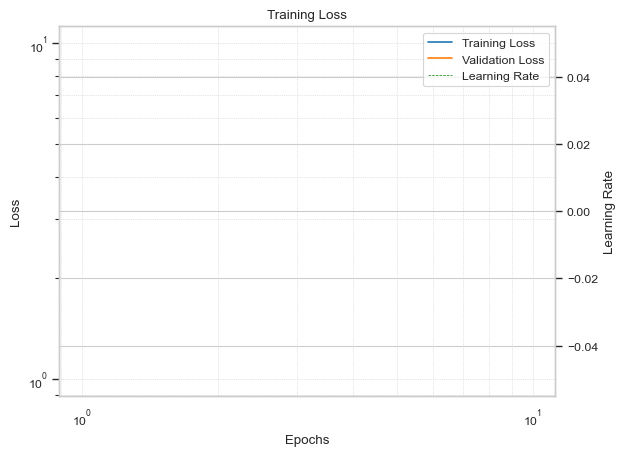

In [14]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

l1 = ax1.loglog(metrics["training_loss"], label="Training Loss")
l2 = ax1.loglog(metrics["validation_loss"], label="Validation Loss")
l3 = ax2.plot(metrics["lr"], label="Learning Rate", color="green", linestyle="--", linewidth=0.5)

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Learning Rate")
plt.title("Training Loss")

plt.legend(l1 + l2 + l3, [l.get_label() for l in l1 + l2 + l3])
ax1.grid(True, which="both", ls=":", linewidth=0.5)
plt.show()

In [15]:
test_data = PDEDataset("data/test_sol.npy", device=DEVICE)
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

NameError: name 'DEVICE' is not defined

In [ ]:
model.eval()
progress_bar = tqdm.tqdm(test_data_loader)

with torch.no_grad():
    test_relative_l2 = 0.0
    for input, target in progress_bar:
        input = input[..., 0]
        target = target[..., 1:, :]
        prediction = model(input, 1.).squeeze(-1)

        loss = torch.sum(relative_l2_error(prediction, target))
        test_relative_l2 += loss.item()
    test_relative_l2 /= len(test_data)

test_relative_l2

100%|██████████| 2/2 [00:00<00:00, 148.30it/s]


0.30217401683330536

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 181712


In [ ]:
# save model to disk
torch.save(model.state_dict(), "models/fno_model.pth")

In [ ]:
test_data = PDEDataset("data/test_sol.npy")
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# pick 10 random samples and draw prediction and target
samples = DataLoader(test_data, batch_size=1, shuffle=True)

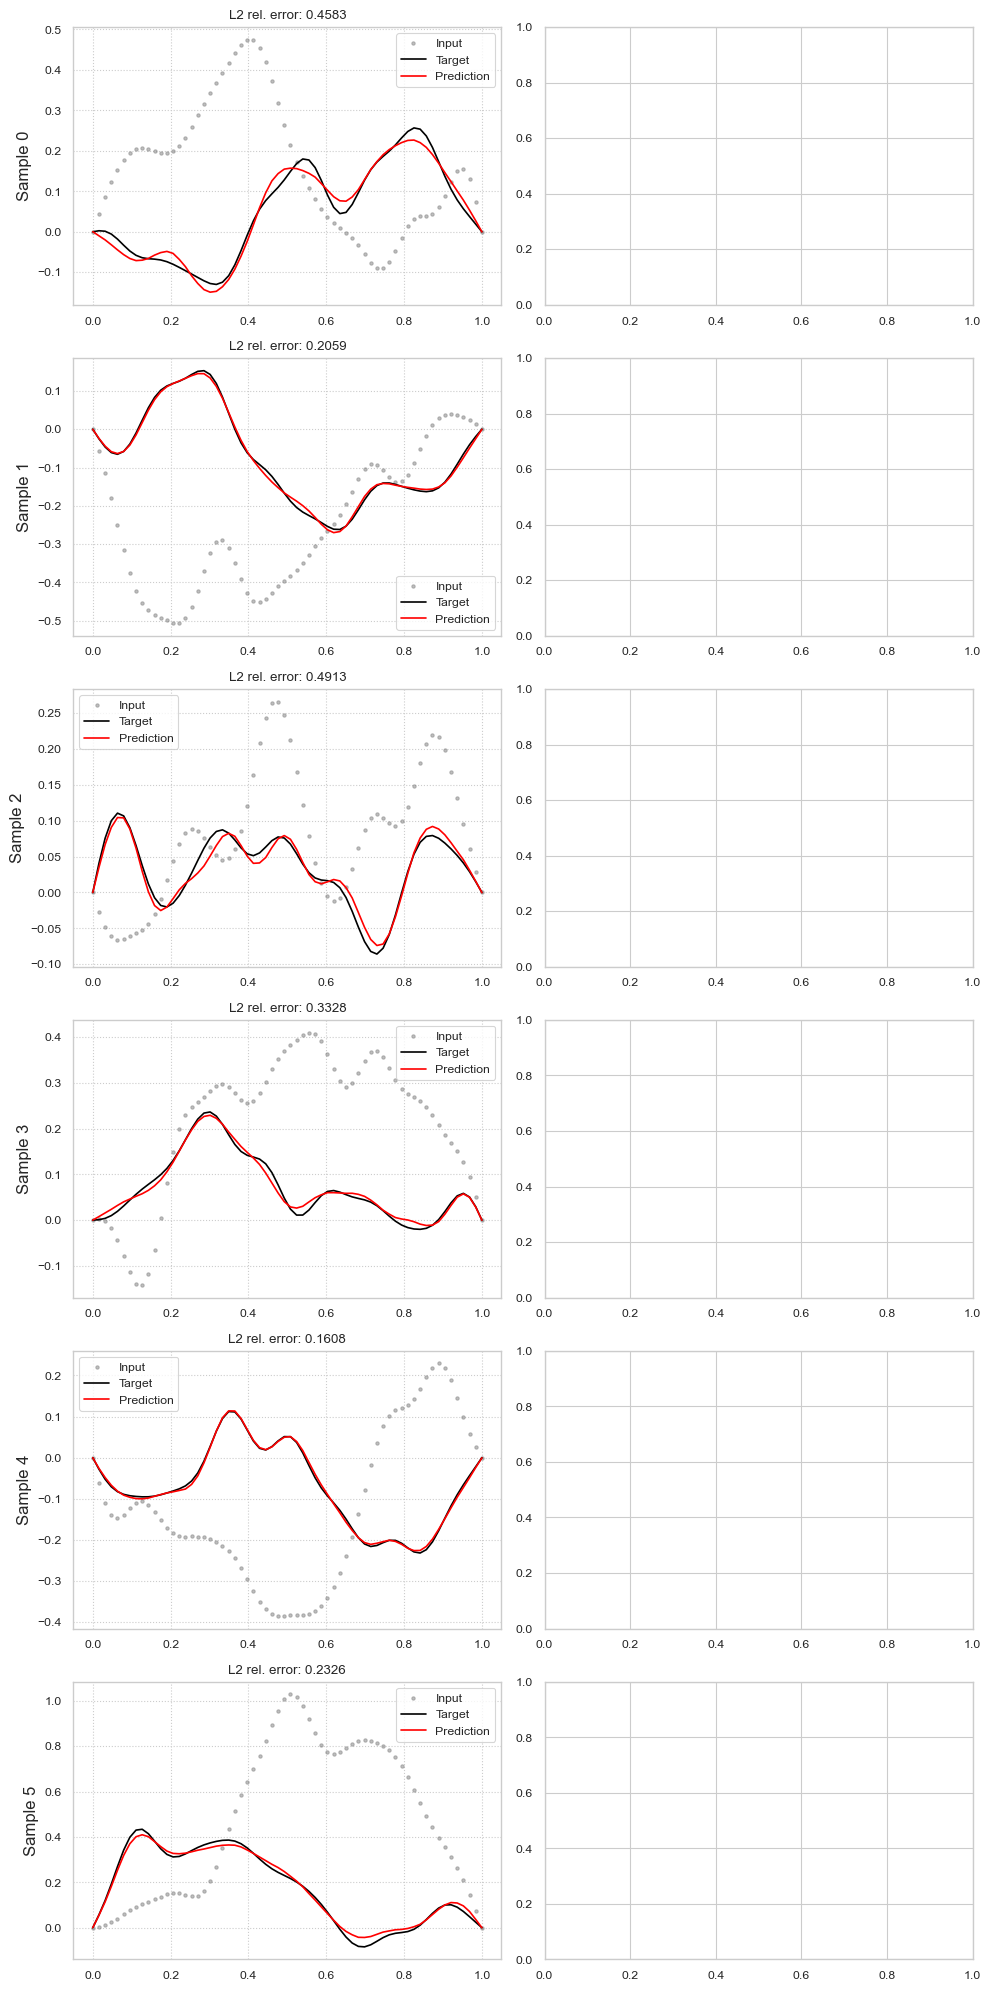

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(10, 20))

model.eval()
with torch.no_grad():
    for i, (ax_rows, sample) in enumerate(zip(axs, samples)):
        input_o, target = sample

        input = input_o[..., 0]
        target = target[..., 1:, :]

        prediction = model(input, 1).squeeze(-1)

        re_l2_error = relative_l2_error(prediction[-1], target[-1]).sum().item()

        ax = ax_rows[0]

        ax.set_ylabel(f"Sample {i}", fontsize=12)

        x_grid = input_o.squeeze(0).numpy()[..., 1][0]
        initial = input_o.squeeze(0).numpy()[..., 0][0]

        ax.scatter(
            x_grid,
            initial,
            label="Input",
            alpha=0.5,
            color="gray",
            marker=".",
        )

        ax.plot(
            x_grid,
            target.squeeze(0)[-1].numpy(),
            label="Target",
            color="black",
        )

        ax.plot(
            x_grid,
            prediction.squeeze(0)[-1].numpy(),
            label="Prediction",
            color="red",
        )

        ax.set_title(f"L2 rel. error: {re_l2_error:.4f}")

        ax.legend()
        ax.grid(True, which="both", ls=":")


plt.tight_layout()
plt.savefig("figures/fno_test_examples.png", dpi=300)